In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('../DATA/RSCCASN.csv',parse_dates=True,index_col='DATE')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
RSCCASN    334 non-null int64
dtypes: int64(1)
memory usage: 5.2 KB


In [11]:
df.columns = ['Sales']

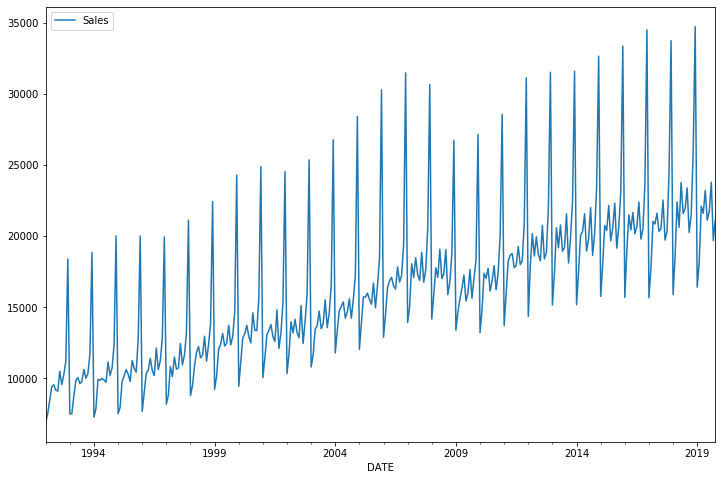

In [12]:
df.plot(figsize=(12,8))

In [13]:
len(df)

334

In [14]:
len(df) - 18

316

In [17]:
test_size=18
test_ind = len(df) - test_size

In [21]:
train = df.iloc[:test_ind] #beginning until test_ind
test = df.iloc[test_ind:] #starting at test_ind go all the way to the end

In [22]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [23]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
scaler = MinMaxScaler()

In [26]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [27]:
scaled_train = scaler.transform(train)

In [28]:
scaled_test = scaler.transform(test)

In [31]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [32]:
len(test)

18

In [34]:
length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=1)

In [38]:
X,y = generator[0]
#predict y based on X

In [44]:
#len(X[0])

In [47]:
#y

In [46]:
#scaled_train

In [48]:
from tensorflow.keras.models import Sequential

In [49]:
from tensorflow.keras.layers import Dense,LSTM

In [50]:
n_features = 1

In [51]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

In [53]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [54]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length,batch_size=1)

In [55]:
model.fit_generator(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 9s 30ms/step - loss: 0.0232 - val_loss: 0.0032
Epoch 2/20
304/304 [==============================] - 9s 28ms/step - loss: 0.0168 - val_loss: 0.0131
Epoch 3/20
304/304 [==============================] - 9s 28ms/step - loss: 0.0113 - val_loss: 0.0016
Epoch 4/20
304/304 [==============================] - 9s 29ms/step - loss: 0.0056 - val_loss: 9.5864e-04
Epoch 5/20
304/304 [==============================] - 9s 28ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 6/20
304/304 [==============================] - 9s 29ms/step - loss: 0.0030 - val_loss: 8.1903e-04
Epoch 7/20
304/304 [==============================] - 9s 28ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/20
304/304 [==============================] - 9s 29ms/step - loss: 0.0012 - val_loss: 7.5642e-04
Epoch 9/20
304/304 [==============================] - 9s 28ms/step - loss: 0.0014 - val_loss: 4.0161e-04
Epoch 10/20
304/304 [==============================] - 9s 28ms/step - loss:

In [56]:
losses = pd.DataFrame(model.history.history)

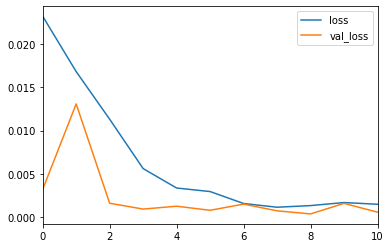

In [58]:
losses.plot()

In [59]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    #replaces first prediction and adds current_pred

In [60]:
true_predictions = scaler.inverse_transform(test_predictions)

In [61]:
test['Predictions'] = true_predictions

/Users/noahhallberg/anaconda3/envs/myTFenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [62]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,21818.421172
2018-06-01,21589,20641.057157
2018-07-01,21919,20889.819273
2018-08-01,23381,22726.289407
2018-09-01,20260,20118.290195
2018-10-01,21473,20851.747082
2018-11-01,25831,24736.285985
2018-12-01,34706,34492.494068
2019-01-01,16410,16060.820804


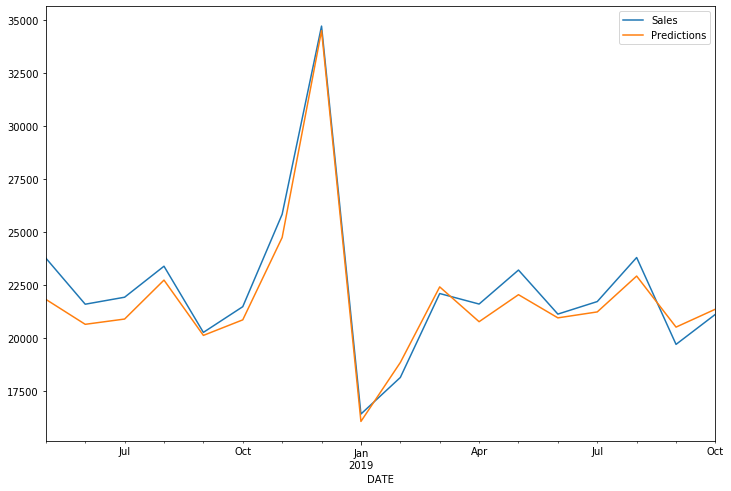

In [63]:
test.plot(figsize=(12,8))

In [64]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [65]:
length = 12
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,
                               length=length,batch_size=1)

In [113]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit_generator(generator,epochs=8)

Epoch 1/8
322/322 [==============================] - 9s 28ms/step - loss: 0.0226
Epoch 2/8
322/322 [==============================] - 9s 28ms/step - loss: 0.0181
Epoch 3/8
322/322 [==============================] - 9s 28ms/step - loss: 0.0097
Epoch 4/8
322/322 [==============================] - 9s 28ms/step - loss: 0.0037
Epoch 5/8
322/322 [==============================] - 9s 28ms/step - loss: 0.0019
Epoch 6/8
322/322 [==============================] - 9s 28ms/step - loss: 0.0022
Epoch 7/8
322/322 [==============================] - 9s 29ms/step - loss: 0.0016
Epoch 8/8
322/322 [==============================] - 9s 29ms/step - loss: 0.0016


In [114]:
forecast = []
# replace periods with whatever forecast length you want

periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    #replaces first prediction and adds current_pred

In [115]:
forecast = full_scaler.inverse_transform(forecast)

In [116]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [117]:
forecast

array([[26672.47196436],
       [36653.19413757],
       [17344.05353785],
       [18930.32625151],
       [22419.26589966],
       [22199.12908792],
       [23719.7207427 ],
       [21965.34596205],
       [22583.84259987],
       [24479.20226002],
       [21001.41965294],
       [22330.91656685]])

In [118]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,
                             freq="MS")
#pandas frequency index

In [119]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [120]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

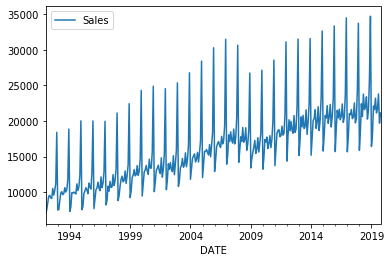

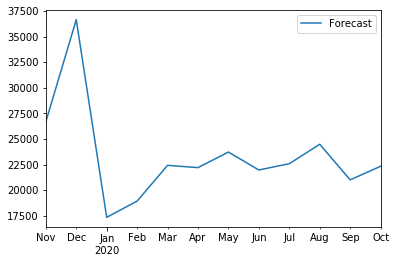

In [121]:
df.plot()
forecast_df.plot()

(576, 611)

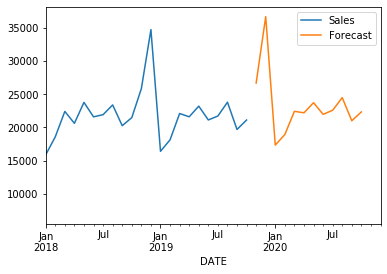

In [123]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')